In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCs_bmimPF6_PR import configuration

In [2]:
m1 = ConcreteModel()

m1.fs = FlowsheetBlock(default={"dynamic": False})

m1.fs.properties = GenericParameterBlock(default=configuration)

m1.fs.F101 = Flash(default={"property_package": m1.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m2 = ConcreteModel()

m2.fs = FlowsheetBlock(default={"dynamic": False})

m2.fs.properties = GenericParameterBlock(default=configuration)

m2.fs.F101 = Flash(default={"property_package": m2.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m3 = ConcreteModel()

m3.fs = FlowsheetBlock(default={"dynamic": False})

m3.fs.properties = GenericParameterBlock(default=configuration)

m3.fs.F101 = Flash(default={"property_package": m3.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

In [3]:
# m1.fs.properties.PR_kappa_A['R32', 'R125'].fix(0.8805)
# m1.fs.properties.PR_kappa_A['R125', 'R32'].fix(0.0288)
# m1.fs.properties.PR_kappa_A['R32', 'bmimPF6'].fix(-0.06394)
# m1.fs.properties.PR_kappa_A['bmimPF6', 'R32'].fix(0.32976)
# m1.fs.properties.PR_kappa_A['bmimPF6', 'R125'].fix(1.4316)
# m1.fs.properties.PR_kappa_A['R125', 'bmimPF6'].fix(-0.0009)

m1.fs.properties.PR_kappa_A['R32', 'R125'].fix(2.4600)
m1.fs.properties.PR_kappa_A['R125', 'R32'].fix(-0.62617)
m1.fs.properties.PR_kappa_A['R32', 'bmimPF6'].fix(-0.06342)
m1.fs.properties.PR_kappa_A['bmimPF6', 'R32'].fix(-0.38827)
m1.fs.properties.PR_kappa_A['bmimPF6', 'R125'].fix(1.56705)
m1.fs.properties.PR_kappa_A['R125', 'bmimPF6'].fix(-0.001198)

m2.fs.properties.PR_kappa_A['R32', 'R125'].fix(0.009)
m2.fs.properties.PR_kappa_A['R125', 'R32'].fix(0.007)
m2.fs.properties.PR_kappa_A['R32', 'bmimPF6'].fix(-0.05450)
m2.fs.properties.PR_kappa_A['bmimPF6', 'R32'].fix(-0.10943)
m2.fs.properties.PR_kappa_A['bmimPF6', 'R125'].fix(0.28636)
m2.fs.properties.PR_kappa_A['R125', 'bmimPF6'].fix(-0.00356)

m3.fs.properties.PR_kappa_A['R32', 'R125'].fix(0.39255)
m3.fs.properties.PR_kappa_A['R125', 'R32'].fix(-0.375437)
m3.fs.properties.PR_kappa_A['R32', 'bmimPF6'].fix(0.06399)
m3.fs.properties.PR_kappa_A['bmimPF6', 'R32'].fix(0.63257)
m3.fs.properties.PR_kappa_A['bmimPF6', 'R125'].fix(-1.195988)
m3.fs.properties.PR_kappa_A['R125', 'bmimPF6'].fix(-0.088142)

m3.fs.properties.PR_kappa_B['R32', 'R125'].fix(-0.389117)
m3.fs.properties.PR_kappa_B['R125', 'R32'].fix(0.3892)
m3.fs.properties.PR_kappa_B['R32', 'bmimPF6'].fix(-0.10862)
m3.fs.properties.PR_kappa_B['bmimPF6', 'R32'].fix(-0.69149)
m3.fs.properties.PR_kappa_B['bmimPF6', 'R125'].fix(1.5687447)
m3.fs.properties.PR_kappa_B['R125', 'bmimPF6'].fix(0.084894)

In [4]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [5]:
# Set pressures to loop over
T = [298]

# Set fraction of feed compositions of HFCs to loop over
P = [10000,20000,30000,40000,50000,60000,70000,80000,100000]

# Make outlet arrays
IL_x = np.zeros((len(T),len(P)))
IL_y = np.zeros((len(T),len(P)))
R32_x = np.zeros((len(T),len(P)))
R32_y = np.zeros((len(T),len(P)))
R125_x = np.zeros((len(T),len(P)))
R125_y = np.zeros((len(T),len(P))) 
L = np.zeros((len(T),len(P)))
V = np.zeros((len(T),len(P))) 

IL_x2 = np.zeros((len(T),len(P)))
IL_y2 = np.zeros((len(T),len(P)))
R32_x2 = np.zeros((len(T),len(P)))
R32_y2 = np.zeros((len(T),len(P)))
R125_x2 = np.zeros((len(T),len(P)))
R125_y2 = np.zeros((len(T),len(P))) 
L2 = np.zeros((len(T),len(P)))
V2 = np.zeros((len(T),len(P))) 

IL_x3 = np.zeros((len(T),len(P)))
IL_y3 = np.zeros((len(T),len(P)))
R32_x3 = np.zeros((len(T),len(P)))
R32_y3 = np.zeros((len(T),len(P)))
R125_x3 = np.zeros((len(T),len(P)))
R125_y3 = np.zeros((len(T),len(P))) 
L3 = np.zeros((len(T),len(P)))
V3 = np.zeros((len(T),len(P))) 

m1.fs.F101.inlet.flow_mol.fix(10)
m1.fs.F101.inlet.temperature.fix(371)
m1.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.216)
m1.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.003)
m1.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.781) 
m1.fs.F101.inlet.pressure.fix(1000000)


m2.fs.F101.inlet.flow_mol.fix(10)
m2.fs.F101.inlet.temperature.fix(371)
m2.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.216)
m2.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.003)
m2.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.781) 
m2.fs.F101.inlet.pressure.fix(1000000)

m3.fs.F101.inlet.flow_mol.fix(10)
m3.fs.F101.inlet.temperature.fix(371)
m3.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.216)
m3.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.003)
m3.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.781) 
m3.fs.F101.inlet.pressure.fix(1000000)

for i in range(len(T)):
    m1.fs.F101.vap_outlet.temperature.fix(T[i])

    m2.fs.F101.vap_outlet.temperature.fix(T[i])
    
    m3.fs.F101.vap_outlet.temperature.fix(T[i])
        
    for j in range(len(P)):

        
        m2.fs.F101.inlet.pressure.fix(P[j])
        m2.fs.F101.vap_outlet.pressure.fix(P[j])

        m1.fs.F101.inlet.pressure.fix(P[j])
        m1.fs.F101.vap_outlet.pressure.fix(P[j])

        m3.fs.F101.inlet.pressure.fix(P[j])
        m3.fs.F101.vap_outlet.pressure.fix(P[j])
        
        m1.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              
        m2.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        m3.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        # solve the model
        status1 = solver.solve(m1, tee = False)
        status2 = solver.solve(m2, tee = False)
        status3 = solver.solve(m3, tee = False)
        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status1.solver.status == SolverStatus.ok) and (status1.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
            IL_y[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
            R32_x[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])
            L[i,j] = value(m1.fs.F101.liq_outlet.flow_mol[0])
            V[i,j] = value(m1.fs.F101.vap_outlet.flow_mol[0])

        if (status2.solver.status == SolverStatus.ok) and (status2.solver.termination_condition == TerminationCondition.optimal):
            IL_x2[i,j] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
            IL_y2[i,j] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
            R32_x2[i,j] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y2[i,j] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x2[i,j] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y2[i,j] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])
            L2[i,j] = value(m2.fs.F101.liq_outlet.flow_mol[0])
            V2[i,j] = value(m2.fs.F101.vap_outlet.flow_mol[0])
           
        if (status3.solver.status == SolverStatus.ok) and (status3.solver.termination_condition == TerminationCondition.optimal):  
            
            IL_x3[i,j] = value(m3.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
            IL_y3[i,j] = value(m3.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
            R32_x3[i,j] = value(m3.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y3[i,j] = value(m3.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x3[i,j] = value(m3.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y3[i,j] = value(m3.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])
            L3[i,j] = value(m3.fs.F101.liq_outlet.flow_mol[0])
            V3[i,j] = value(m3.fs.F101.vap_outlet.flow_mol[0])
            
            #Change this to feasible
            print("Running temperature:",T[i],"and HFC feed fraction",P[j])

        else:
            print('Infeasible.')

Running temperature: 298 and HFC feed fraction 10000
Running temperature: 298 and HFC feed fraction 20000
Running temperature: 298 and HFC feed fraction 30000
Running temperature: 298 and HFC feed fraction 40000
Running temperature: 298 and HFC feed fraction 50000
Running temperature: 298 and HFC feed fraction 60000
Running temperature: 298 and HFC feed fraction 70000
Running temperature: 298 and HFC feed fraction 80000
Running temperature: 298 and HFC feed fraction 100000


In [6]:
VR32_1 = np.zeros((len(T),len(P)))
VR125_1 = np.zeros((len(T),len(P)))
LR32_1 = np.zeros((len(T),len(P)))
LR125_1 = np.zeros((len(T),len(P)))

VR32_2 = np.zeros((len(T),len(P)))
VR125_2 = np.zeros((len(T),len(P)))
LR32_2 = np.zeros((len(T),len(P)))
LR125_2 = np.zeros((len(T),len(P)))

VR32_3 = np.zeros((len(T),len(P)))
VR125_3 = np.zeros((len(T),len(P)))
LR32_3 = np.zeros((len(T),len(P)))
LR125_3 = np.zeros((len(T),len(P)))

for i in range(len(T)):
    for j in range(len(P)):
        VR32_1[i,j] = R32_y[i,j] * V[i,j]
        VR125_1[i,j] = R125_y[i,j] * V[i,j]
        LR32_1[i,j] = R32_x[i,j] * L[i,j]
        LR125_1[i,j] = R125_x[i,j] * L[i,j]

        VR32_2[i,j] = R32_y2[i,j] * V2[i,j]
        VR125_2[i,j] = R125_y2[i,j] * V2[i,j]
        LR32_2[i,j] = R32_x2[i,j] * L2[i,j]
        LR125_2[i,j] = R125_x2[i,j] * L2[i,j]
        
        VR32_3[i,j] = R32_y3[i,j] * V3[i,j]
        VR125_3[i,j] = R125_y3[i,j] * V3[i,j]
        LR32_3[i,j] = R32_x3[i,j] * L3[i,j]
        LR125_3[i,j] = R125_x3[i,j] * L3[i,j]
        
PVR32_1 = np.zeros((len(T),len(P)))
PVR125_1 = np.zeros((len(T),len(P)))
PLR32_1 = np.zeros((len(T),len(P)))
PLR125_1 = np.zeros((len(T),len(P)))

PVR32_2 = np.zeros((len(T),len(P)))
PVR125_2 = np.zeros((len(T),len(P)))
PLR32_2 = np.zeros((len(T),len(P)))
PLR125_2 = np.zeros((len(T),len(P)))

PVR32_3 = np.zeros((len(T),len(P)))
PVR125_3 = np.zeros((len(T),len(P)))
PLR32_3 = np.zeros((len(T),len(P)))
PLR125_3 = np.zeros((len(T),len(P)))

for i in range(len(T)):
    for j in range(len(P)):
        PVR32_1[i,j] = VR32_1[i,j]/2.16
        PVR125_1[i,j] = VR125_1[i,j]/0.03
        PLR32_1[i,j] = LR32_1[i,j]/2.16
        PLR125_1[i,j] = LR125_1[i,j]/0.03

        PVR32_2[i,j] = VR32_2[i,j]/2.16
        PVR125_2[i,j] = VR125_2[i,j]/0.03
        PLR32_2[i,j] = LR32_2[i,j]/2.16
        PLR125_2[i,j] = LR125_2[i,j]/0.03
       
        PVR32_3[i,j] = VR32_3[i,j]/2.16
        PVR125_3[i,j] = VR125_3[i,j]/0.03
        PLR32_3[i,j] = LR32_3[i,j]/2.16
        PLR125_3[i,j] = LR125_3[i,j]/0.03

In [7]:
P1 = np.zeros(len(P))

for i in range(len(P)):
    P1[i] = P[i]/1e6

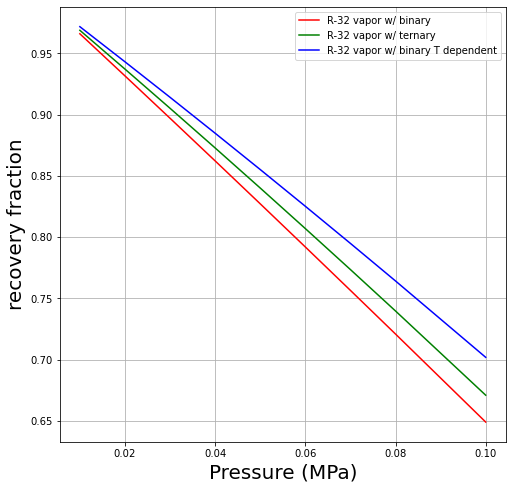

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

plt.plot(P1,PVR32_1[0,:],linestyle='-', color='red',label="R-32 vapor w/ binary")  
plt.plot(P1,PVR32_2[0,:],linestyle='-', color='green',label="R-32 vapor w/ ternary") 
plt.plot(P1,PVR32_3[0,:],linestyle='-', color='blue',label="R-32 vapor w/ binary T dependent") 

# ax.set_title("recovery fraction",fontsize=20)
plt.xlabel('Pressure (MPa)',fontsize=20)
plt.ylabel('recovery fraction',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

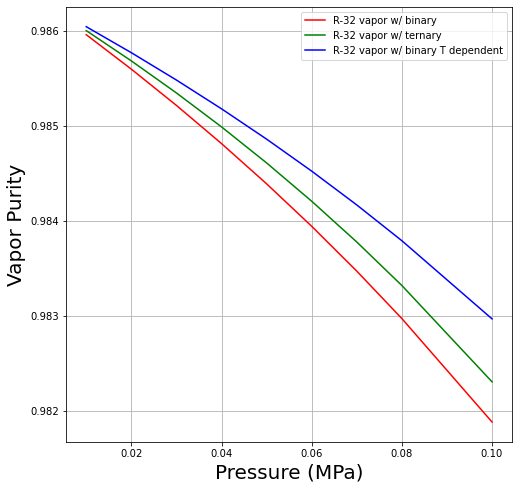

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

plt.plot(P1,R32_y[0,:],linestyle='-', color='red',label="R-32 vapor w/ binary")  
plt.plot(P1,R32_y2[0,:],linestyle='-', color='green',label="R-32 vapor w/ ternary") 
plt.plot(P1,R32_y3[0,:],linestyle='-', color='blue',label="R-32 vapor w/ binary T dependent") 

# ax.set_title("recovery fraction",fontsize=20)
plt.xlabel('Pressure (MPa)',fontsize=20)
plt.ylabel('Vapor Purity',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

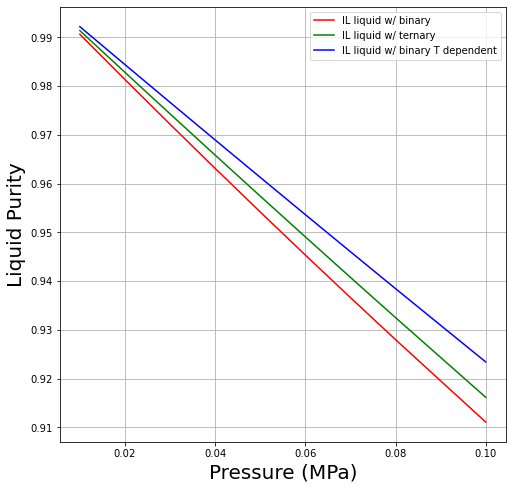

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

plt.plot(P1,IL_x[0,:],linestyle='-', color='red',label="IL liquid w/ binary")  
plt.plot(P1,IL_x2[0,:],linestyle='-', color='green',label="IL liquid w/ ternary") 
plt.plot(P1,IL_x3[0,:],linestyle='-', color='blue',label="IL liquid w/ binary T dependent") 

# ax.set_title("recovery fraction",fontsize=20)
plt.xlabel('Pressure (MPa)',fontsize=20)
plt.ylabel('Liquid Purity',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()